In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

with open('./data/LegalBench-RAG/corpus/maud/Domtar Corporation_Paper Excellence Canada Group.txt') as f:
    data = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        # multiple newlines
        r'\n\n\s*',
        # single newline
        r'\n\s*',
        # sentence
        r'(?<=[.?!])\s+',
        # clauses
        ';', ':', ',',
    ],
    chunk_size=200,
    chunk_overlap=0,
    add_start_index=True,
    is_separator_regex=True,
)


raw_sentences = text_splitter.split_text(data)

print(f'sentence count: {len(raw_sentences)}')
raw_sentences[:10]

sentence count: 2430


['\ufeffExhibit 2.1 \n\n\nExecution Version     AGREEMENT AND PLAN OF MERGER \n\n\namong \n\n\nDOMTAR CORPORATION, \n\n\nKARTA HALTEN B.V., \n\n\nand \n\n\nPEARL MERGER SUB INC. \n\n\nand \n\n\nPAPER EXCELLENCE B.V. \n\n\nand',
 'HERVEY INVESTMENTS B.V. \n\n\nDated as of May 10, 2021    \n\n\n\n\n\n\n\n\n________________',
 '\n\n\nTABLE OF CONTENTS         Page  ARTICLE I    DEFINITIONS    Section 1.1   Definitions    6  Section 1.2   Table of Definitions    20  Section 1.3   Other Definitional and Interpretative Provisions    22  ARTICLE II    THE MERGER',
 '; EFFECT ON THE CAPITAL STOCK',
 '; PAYMENT    Section 2.1   The Merger    23  Section 2.2   Closing    23  Section 2.3   Effective Time    23  Section 2.4   Surviving Corporation Matters    24  Section 2.5   Effect of the Merger on Capital Stock of the Company and Merger Sub    24  Section 2.6   Certain Adjustments    25  Section 2.7   Appraisal Shares    25  Section 2.8   Payment for Company Stock    25  Section 2.9   Further As

In [2]:
max(len(x) for x in max(data.splitlines(), key=len).split('. '))

2090

In [9]:
import re

re.split('\n', data)[:10]

['This Privacy Policy informs you of your choices and our practices regarding any information you provide to us.',
 'Your continued use of our products and services constitutes your acceptance to this Privacy Policy and any updates.',
 'It is a big responsibility to try our best to protect your information and put you in control.',
 'We may from time to time revise or add specific instructions, policies and terms to this Privacy Policy.',
 'Whenever we make any changes to this Privacy Policy that are important for you to know about, we will notify you via Keep App or other means before the changes become effective.',
 'Your click means that you agree with the changes to this Privacy Policy and would like to continue to use our products and services.',
 '  If you have any question about this policy, please send email to:support@gotokeep.com.',
 'We collect the information to provide you a better service  for example, to:',
 'Provide our services.',
 'We need your age, height and weight 

In [5]:
import re
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

def split_to_spans(text):
    
    docs = text_splitter.create_documents(text)
    spans = []
    for doc in docs:
        start = doc.metadata['start_index']
        spans.append((start, start + len(doc.page_content)))
    return spans

def split_to_spans(text: str, chunk_size: int=200):
    """
    Splits a text into spans, first by newline characters unconditionally,
    and then by other separators for chunks that are too large.

    Args:
        text: The input string to split.

    Returns:
        A list of tuples, where each tuple is a (start, end) span of a chunk.
    """
    final_spans = []

    # Stage 1: Split the text by newline characters unconditionally.
    # We use splitlines(keepends=True) to correctly handle all newline variations
    # and keep track of the original character offsets.
    lines = text.splitlines(keepends=True)
    initial_spans = []
    current_offset = 0
    for line in lines:
        start = current_offset
        end = start + len(line)
        
        # We want the content of the line, excluding the trailing newline character
        # for the purpose of creating the initial chunks.
        line_content_end = end
        if line.endswith('\n'):
            line_content_end -= 1
        if line.endswith('\r'): # Handles '\r' and '\r\n'
             line_content_end -=1

        if start < line_content_end:
            initial_spans.append((start, line_content_end))
        
        current_offset = end

    # Stage 2: For any chunk that is larger than the chunk_size, split it further
    # using the remaining separators.
    remaining_separators = [
        # Sentence boundaries
        r'(?<=[.?!])\s+',
        # Clause boundaries
        # ';', ':', ',',
    ]

    # We create a secondary splitter for the oversized chunks.
    # add_start_index=True is crucial for getting the relative start position of sub-chunks.
    secondary_splitter = RecursiveCharacterTextSplitter(
        separators=remaining_separators,
        chunk_size=chunk_size,
        chunk_overlap=0,
        add_start_index=True,
        is_separator_regex=True,
    )

    for start, end in initial_spans:
        chunk_text = text[start:end]

        # If the chunk from the initial newline split is within the size limit, we keep it.
        if len(chunk_text) <= chunk_size:
            if chunk_text.strip():  # Ensure we don't add chunks of only whitespace.
                final_spans.append((start, end))
        # If the chunk is too large, we split it with the secondary splitter.
        else:
            # The splitter's `split_documents` method can provide metadata like start_index.
            # We wrap our chunk in a Document object to leverage this.
            doc = Document(page_content=chunk_text)
            sub_docs = secondary_splitter.split_documents([doc])
            
            for sub_doc in sub_docs:
                # The start_index in the metadata is relative to the start of `chunk_text`.
                sub_chunk_start_relative = sub_doc.metadata.get('start_index', 0)
                sub_chunk_text = sub_doc.page_content
                sub_chunk_end_relative = sub_chunk_start_relative + len(sub_chunk_text)

                # We calculate the final span's indices relative to the original text.
                final_start = start + sub_chunk_start_relative
                final_end = start + sub_chunk_end_relative
                final_spans.append((final_start, final_end))

    return final_spans

sample_text = data

# Get the spans
spans = split_to_spans(sample_text)
chunks = [sample_text[start:end] for start, end in spans]

In [10]:
max(chunks, key=len)

'“Company Material Adverse Effect” means any effect, change, condition, fact, development, occurrence or event that, individually or in the aggregate, has had, or would reasonably be expected to have, a material adverse effect on the financial condition, business, assets, liabilities or results of operations of the Company and its Subsidiaries, taken as a whole, excluding any effect, change, condition, fact, development, occurrence or event resulting from or arising out of (i) general economic or political conditions in the United States or any foreign jurisdiction or in securities, credit or financial markets, including changes in interest rates and changes in exchange rates, (ii) changes or conditions generally affecting the industries (including changes in prices for raw materials and finished products), markets or geographical areas in which the Company or any of its Subsidiaries operates (including COVID-19 Measures), (iii) any outbreak or escalation of hostilities, acts of war (w

In [2]:
def combine_sentences(sentences, pad=2):
    combined_sentences = []
    for i in range(len(sentences)):
        window = sentences[max(0, i - pad):i + 1 + pad]
        combined_sentences.append(' '.join(window))
    return combined_sentences
combined_sentences = combine_sentences(raw_sentences)
combined_sentences[:3]

['  At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.',
 '  At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post rev

In [3]:
from sentence_transformers import SentenceTransformer
from transformers import BitsAndBytesConfig


model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-8B",
    model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
embeddings = model.encode(
    combined_sentences,
    show_progress_bar=True,
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
%matplotlib inline

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def pairwise_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        distances.append(1 - embeddings[i] @ embeddings[i + 1])
    return distances
    
distances = pairwise_cosine_distances(embeddings)

Using matplotlib backend: inline


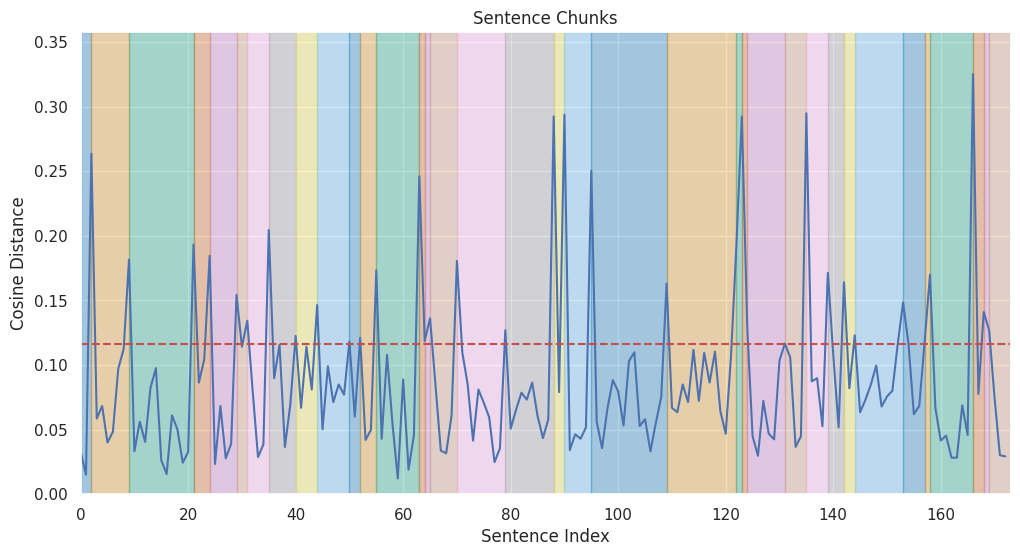

In [11]:
%matplotlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


PERCENTILE = 80

# plot distances
plt.figure(figsize=(12, 6))
sns.lineplot(distances);

# set bounds
y_upper = 1.1 * max(distances)
plt.xlim(0, len(distances))
plt.ylim(0, y_upper)

# draw threshold line

threshold = np.percentile(distances, PERCENTILE)
plt.axhline(threshold, color='r', linestyle='--')

colors = sns.color_palette('colorblind')
threshold_idxs = np.where(distances > threshold)[0]

chunk_starts = [0] + list(threshold_idxs)
chunk_ends = list(threshold_idxs) + [len(distances)]
for i, (start, end) in enumerate(zip(chunk_starts, chunk_ends)):
    plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.3, label=f'Chunk {i}')

plt.title('Sentence Chunks')
plt.xlabel('Sentence Index')
plt.ylabel('Cosine Distance')
plt.show()

In [12]:
chunks = []
chunk_idxs = [0] + list(threshold_idxs + 1) + [len(distances)]  # The split index is after the high distance 
for start, end in zip(chunk_idxs[:-1], chunk_idxs[1:]):
    chunks.append(' '.join(raw_sentences[start:end]))

In [18]:
for i, chunk in enumerate(chunks[:5]):
    buffer = 200
    
    print (f"Chunk #{i} (length={len(chunk)})")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0 (length=527)
At Fiverr we care about your privacy. We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent. We do not disclose it to ot
...
ng - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #1 (length=1429)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser
...
ty service providers acting on our behalf. These providers may be based in countries that do not provide an equivalent level of protection for privacy as that enjoyed in the country in which you live.


Chunk #2 (length=1564)
In that case, we will provide for adequate safeguards to protect your personal information. You can exercise your righ

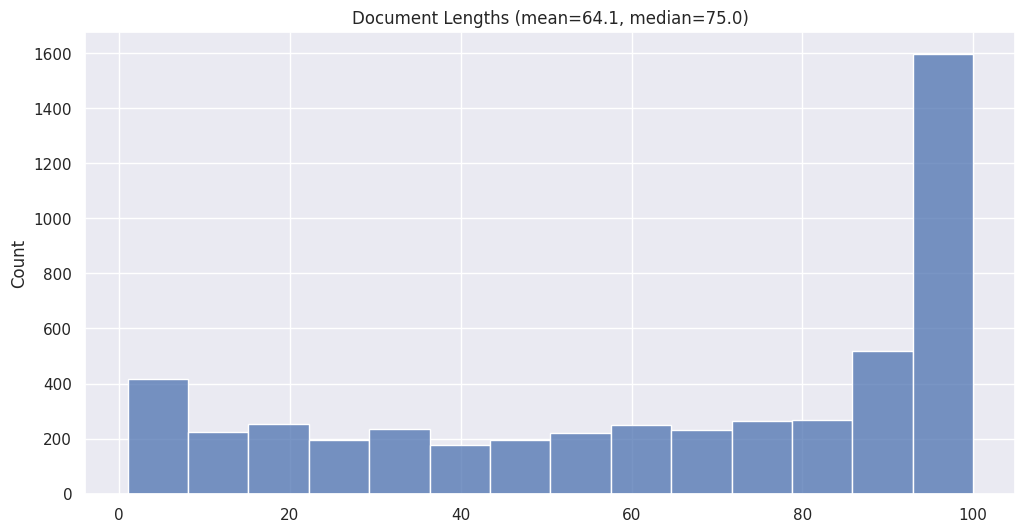

In [4]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(chunk) for chunk in raw_sentences]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f})")
plt.show()

In [19]:
max(raw_sentences, key=len)

'to respond to a subpoena or court order, judicial process or to regulatory authorities, if we believe we are required to do so by law, or that doing so is reasonably necessary to comply with legal processes; when we believe it necessary or appropriate to disclose personal information to law enforcement authorities, such as to investigate actual or suspected fraud or violations of law, breaches of security, or breaches of this Policy; to respond to claims against us; and to protect the rights, property, or personal safety of Fiverr, our customers, or the public;'

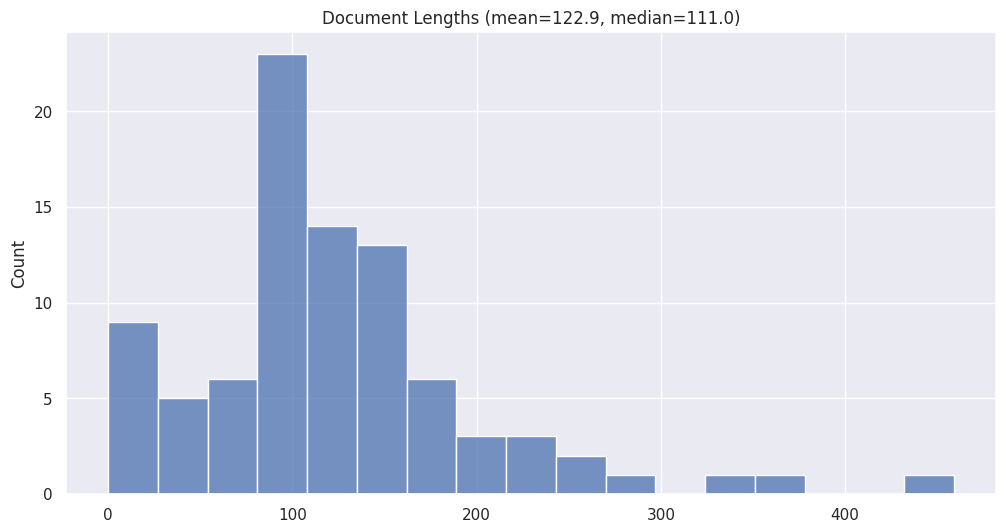

In [10]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(chunk) for chunk in re.split('\n', data)]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f})")
plt.show()


In [ ]:
import re


def split_recursive_sentences(text, patterns, chunk_size=200):
    patterns = [re.compile(pattern)]
    spans = []
    def dfs(pattern_idx, text, offset):
        pattern = patterns[pattern_idx]
    dfs(0, text, 0)
    return spans


def split_to_spans_by_regex(regex, text):
    spans = []
    prev = 0
    for match in regex.finditer(text):
        spans.append((prev, match.start()))
        prev = match.end()
    if prev < len(text):
        spans.append((prev, len(text)))
    return spans

(array([4.139e+03, 1.660e+02, 3.400e+01, 1.200e+01, 7.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([1.0000e+00, 1.2320e+03, 2.4630e+03, 3.6940e+03, 4.9250e+03,
        6.1560e+03, 7.3870e+03, 8.6180e+03, 9.8490e+03, 1.1080e+04,
        1.2311e+04]),
 <BarContainer object of 10 artists>)

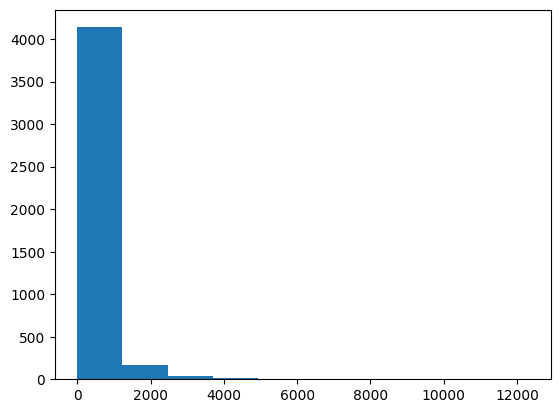

In [8]:
%matplotlib inline


import json
import os
import random

from lib.load import extract_data, LEGALBENCH_RAG_PATH
import matplotlib.pyplot as plt
import spacy

from lib.load import extract_data, load_benchmark_corpus

def load_benchmark_corpus(subset="maud"):
    with open(os.path.join(LEGALBENCH_RAG_PATH, "benchmarks", f"{subset}.json")) as f:
        benchmark = json.load(f)['tests']
    
    corpus = {}
    corpus_path = os.path.join(LEGALBENCH_RAG_PATH, "corpus", subset)

    random.seed(42)
    
    for document in random.sample(os.listdir(corpus_path), 5):
        with open(os.path.join(corpus_path, document)) as f:
            corpus[document] = f.read()

    benchmark_sample = []
    for test in benchmark:
        file_path = test["snippets"][0]["file_path"]
        filename = os.path.basename(file_path)
        if filename in corpus:
            benchmark_sample.append(test)
            
    return benchmark_sample, corpus
benchmark, corpus = load_benchmark_corpus()

extract_data()
benchmark, corpus = load_benchmark_corpus()

nlp = spacy.load('en_core_web_sm')

length = []
sents = []
for data in corpus.values():
    doc = nlp(data)
    sents += [data[sent.start_char:sent.end_char] for sent in doc.sents]
    length += [sent.end_char - sent.start_char for sent in doc.sents]

plt.hist(length)

(array([1.599e+03, 2.640e+02, 1.050e+02, 1.010e+02, 9.300e+01, 2.300e+01,
        5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([1.0000e+00, 8.3590e+02, 1.6708e+03, 2.5057e+03, 3.3406e+03,
        4.1755e+03, 5.0104e+03, 5.8453e+03, 6.6802e+03, 7.5151e+03,
        8.3500e+03]),
 <BarContainer object of 10 artists>)

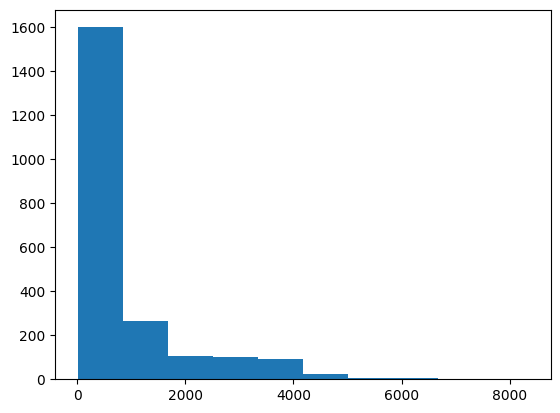

In [10]:
import re

length = []
sents = []
for data in corpus.values():
    xs = re.split(r'\n+', data)
    sents += xs
    length += [len(s) for s in xs]

plt.hist(length)

In [11]:
max(sents, key=len)

' (d)           Prior to the Closing, the Company shall use its reasonable best efforts to provide, and shall use its reasonable efforts to cause its Representatives to provide, in each case at Parent’s sole cost and expense, such cooperation as is customary and reasonably requested by Parent in connection with the arrangement of the Debt Financing (provided that such requested cooperation does not unreasonably interfere with the ongoing operations of the Company or any of the Company Subsidiaries), including by using reasonable best efforts to: (i) make management (with appropriate seniority and expertise to participate) of the Company available to participate in a reasonable number of meetings, presentations, road shows, due diligence sessions and sessions with rating agencies, including a reasonable and limited number of customary one-on-one meetings and calls with prospective Lenders and purchasers of the Financing, in each case, at reasonable times and with reasonable advance noti